In [10]:
# load libs
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [11]:
# define torus class
class torus(object):
    def __init__(self, r_major, r_minor, show_defaults=False, *args, **kwargs):
        self.r_major = float(r_major)
        self.r_minor = float(r_minor)
        self.torus_type = 'Ring' if r_major>r_minor else ('Spindle' if r_major<r_minor else 'Horn')
        default_vals = {'res':100,'err':0.1,'goop_factor':4}
        for key in default_vals.keys():
            try:
                self.__dict__[key]=kwargs[key]
            except:
                if show_defaults:
                    print(f'{key} = {default_vals[key]} by default')
                self.__dict__[key]=default_vals[key]
        #self.theta = self.theta()
        #self.phi   = self.phi()
        
    def __str__(self, verbose=False):
        R = self.r_major
        r = self.r_minor
        return f'{self.torus_type} torus with major radius {R} and minor radius {r}'
                
    def theta(self,**kwargs_t):
        t_vals = {'tmin':0,'tmax':2*np.pi,'res':self.res}
        for key in t_vals.keys():
            try:
                t_vals[key] = kwargs_t[key]
            except:
                t_vals[key] = t_vals[key]
        return np.linspace(t_vals['tmin'],t_vals['tmax'], t_vals['res'])
        
    def phi(self,**kwargs_p):
        p_vals = {'pmin':0,'pmax':2*np.pi,'res':self.res}
        for key in p_vals.keys():
            try:
                p_vals[key] = kwargs_p[key]
            except:
                p_vals[key] = p_vals[key]
        return np.linspace(p_vals['pmin'],p_vals['pmax'], p_vals['res'])
    
    def x_range(self):
        R = self.r_major
        r = self.r_minor
        t = self.theta()
        p = self.phi()
        return (R+r*np.cos(t))*np.cos(p)
    
    def y_range(self):
        R = self.r_major
        r = self.r_minor
        t = self.theta()
        p = self.phi()
        return (R+r*np.cos(t))*np.sin(p)
    
    def z_range(self):
        r = self.r_minor
        t = self.theta()
        return r*np.sin(t)
    
    def point(self, theta, phi, closest=False):
        R = self.r_major
        r = self.r_minor
        if not closest:
            T = theta
            P = phi
        elif closest:
            cti = np.abs(theta - self.theta()).argmin()
            cpi = np.abs(phi - self.phi()).argmin()
            T = self.theta()[cti]
            P = self.phi()[cpi]
        x = (R+r*np.cos(T))*np.cos(P)
        y = (R+r*np.cos(T))*np.sin(P)
        z = r*np.sin(T)
        return np.array([x,y,z])
    
    def tangent(self, theta, phi, D, normalized=False, closest=False):
        R = self.r_major
        r = self.r_minor
        if not closest:
            T = theta
            P = phi
        elif closest:
            cti = np.abs(theta - self.theta()).argmin()
            cpi = np.abs(phi - self.phi()).argmin()
            T = self.theta()[cti]
            P = self.phi()[cpi]
        if D=='theta':
            x = -r*np.sin(T)*np.cos(P)
            y = -r*np.sin(T)*np.sin(P)
            z = r*np.cos(T)
        elif D=='phi':
            x = -(R+r*np.cos(T))*np.sin(P)
            y = (R+r*np.cos(T))*np.cos(P)
            z = np.zeros_like(T)
        else:
            raise ValueError('Derivative must be either \"theta" or \"phi". Other tangent vectors can be computed manually.')
        tgnt_vec = np.array([x,y,z])
        norm = 1# tgnt_vec.dot(tgnt_vec)#*int(normalized) + int(not normalized)
        return tgnt_vec/norm
    
    def normal(self, theta, phi, normalized=False):
        R = self.r_major
        r = self.r_minor
        tgnt_theta = self.tangent(theta, phi, 'theta')
        tgnt_phi   = self.tangent(theta, phi, 'phi')
        srfc_nrml  = np.cross(tgnt_phi, tgnt_theta,axisa=0,axisb=0)
        nrml_ax    = len(srfc_nrml.shape)
        swap       = tuple(list(range(nrml_ax))[-1:]+list(range(nrml_ax))[0:-1])
        return np.transpose(srfc_nrml, axes=swap)

In [67]:
# This cell defines my torus 
rmaj = 3.0
rmin = 2.0
T = torus(r_major=rmaj,r_minor=rmin)

In [68]:
# this cell initializes a bunch of arrays defining the sets I want to plot in the next cell
sql = max([rmaj,rmin])+1.0
R = T.r_major
r = T.r_minor
theta, phi = np.meshgrid(T.theta(),T.phi())

X = (R+r*np.cos(theta))*np.cos(phi)
Y = (R+r*np.cos(theta))*np.sin(phi)
Z = r*np.sin(theta)

ang_inc = np.pi/24
ang_theta = np.arange(0, 2*np.pi+ang_inc, ang_inc)
ang_phi = np.arange(0, 2*np.pi+ang_inc, ang_inc) 
th_tan, ph_tan = np.meshgrid(ang_theta, ang_phi)

x_tan, y_tan, z_tan = T.point(th_tan, ph_tan)
p_phi, q_phi, r_phi = T.tangent(th_tan, ph_tan, 'phi')
p_theta, q_theta, r_theta = T.tangent(th_tan, ph_tan, 'theta')

p_nrm, q_nrm, r_nrm = T.normal(th_tan, ph_tan)

cres = 100
pnts = 12

const_phi   = -np.pi/2
const_theta = (np.pi/2)

xc,yc,zc = T.point(np.linspace(0,2*np.pi,cres),const_phi*np.ones(cres))
xf,yf,zf = T.point(np.linspace(0,2*np.pi,pnts),const_phi*np.ones(pnts))
pp,qp,rp = T.tangent(np.linspace(0,2*np.pi,pnts),const_phi*np.ones(pnts),'phi')
pt,qt,rt = T.tangent(np.linspace(0,2*np.pi,pnts),const_phi*np.ones(pnts),'theta')
pn,qn,rn = T.normal(np.linspace(0,2*np.pi,pnts),const_phi*np.ones(pnts))

xc1,yc1,zc1 = T.point(const_theta*np.ones(cres), np.linspace(0,2*np.pi,cres))
xf1,yf1,zf1 = T.point(const_theta*np.ones(pnts), np.linspace(0,2*np.pi,pnts))
pp1,qp1,rp1 = T.tangent(const_theta*np.ones(pnts), np.linspace(0,2*np.pi,pnts),'phi')
pt1,qt1,rt1 = -T.tangent(const_theta*np.ones(pnts), np.linspace(0,2*np.pi,pnts),'theta')
pn1,qn1,rn1 = T.normal(const_theta*np.ones(pnts), np.linspace(0,2*np.pi,pnts))

wnd = 6
xc2,yc2,zc2 = T.point(np.linspace(0,wnd*2*np.pi,wnd*cres), np.linspace(0,2*np.pi,wnd*cres))

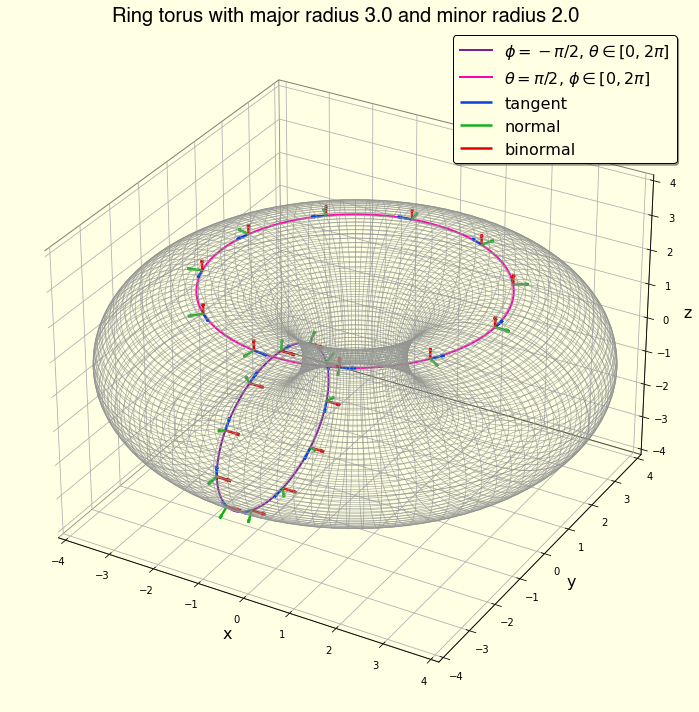

In [69]:
# This just determines if you're plotting a bunch of normal vectors or if you're plotting curves of fixed theta/phi
fuzzy = 0
curve = not fuzzy

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

if fuzzy:
    ax.plot_wireframe(X, Y, Z, linewidth = 0.7,antialiased=True, color = 'xkcd:crimson', rstride = 1, cstride = 1,alpha=0.45)
    #ax.plot_surface(X, Y, Z, linewidth = 1.5,antialiased=True, color = 'xkcd:black', rstride = 1, cstride = 1,alpha=1.0)
    #ax.quiver(x_tan,y_tan,z_tan,p_phi,q_phi,r_phi, length=0.1, normalize=True, color='xkcd:green')
    #ax.quiver(x_tan,y_tan,z_tan,p_theta,q_theta,r_theta, length=0.1, normalize=True, color='xkcd:blue')
    ax.quiver(x_tan,y_tan,z_tan,p_nrm,q_nrm,r_nrm,linewidth=1.0,length=0.15,normalize=True,color='xkcd:teal',alpha=0.6,label='surface normal')
    ax.legend(frameon=True,markerscale=1.0,fancybox=True,fontsize=16,facecolor='xkcd:off white',shadow=True,edgecolor='xkcd:black')
elif curve:
    vec_alpha = 1.0
    vec_width = 2.5
    vec_length= 0.3
    crv_width = 2.0

    ax.plot_wireframe(X, Y, Z, linewidth = 0.7,antialiased=True, color = 'xkcd:grey', rstride = 1, cstride = 1,alpha=0.75)
    ax.quiver(xf,yf,zf, pt,qt,rt,linewidth=vec_width,length=vec_length,normalize=True,color='xkcd:blue',alpha=vec_alpha,label='tangent')
    ax.quiver(xf,yf,zf, pn,qn,rn,linewidth=vec_width,length=vec_length,normalize=True,color='xkcd:green',alpha=vec_alpha,label='normal')
    ax.quiver(xf,yf,zf, pp,qp,rp,linewidth=vec_width,length=vec_length,normalize=True,color='xkcd:red',alpha=vec_alpha,label='binormal')
    ax.plot(xc,yc,zc,linewidth=crv_width,alpha=1.0,color='xkcd:purple',label=f'$\phi=-\pi/2$, $\\theta\in[0,2\pi]$')
    
    ax.quiver(xf1,yf1,zf1, pt1,qt1,rt1,linewidth=vec_width,length=vec_length,normalize=True,color='xkcd:green',alpha=vec_alpha ) #,label='tangent')
    ax.quiver(xf1,yf1,zf1, pn1,qn1,rn1,linewidth=vec_width,length=vec_length,normalize=True,color='xkcd:red',alpha=vec_alpha ) #,label='normal')
    ax.quiver(xf1,yf1,zf1, pp1,qp1,rp1,linewidth=vec_width,length=vec_length,normalize=True,color='xkcd:blue',alpha=vec_alpha ) #,label='binormal')
    ax.plot(xc1,yc1,zc1,linewidth=crv_width,alpha=1.0,color='xkcd:bright pink',label='$\\theta=\pi/2$, $\phi\in[0,2\pi]$')
    #labels for curves should be changed for different values of const_phi and const_theta in the previous cell
    
    ax.legend(frameon=True,markerscale=1.0,fancybox=True,fontsize=16,facecolor='xkcd:off white',shadow=True,edgecolor='xkcd:black')
else:
    ax.plot_wireframe(X, Y, Z, linewidth = 0.7,antialiased=True, color = 'xkcd:grey', rstride = 1, cstride = 1,alpha=0.75)
    ax.plot(xc2,yc2,zc2,linewidth=crv_width,alpha=1.0,color='xkcd:bright pink',label='$\\theta=\pi/2$, $\phi\in[0,2\pi]$')
    
ax.set_xlim(-sql,sql)
ax.set_ylim(-sql,sql)
ax.set_zlim(-sql,sql)

ax.set_facecolor('xkcd:off white')
ax.grid(True)

ax.xaxis.pane.fill = True
ax.yaxis.pane.fill = True
ax.zaxis.pane.fill = True

ax.xaxis.pane.set_facecolor('xkcd:off white')
ax.yaxis.pane.set_facecolor('xkcd:off white')
ax.zaxis.pane.set_facecolor('xkcd:off white')

ax.xaxis.pane.set_edgecolor('xkcd:black')
ax.yaxis.pane.set_edgecolor('xkcd:black')
ax.zaxis.pane.set_edgecolor('xkcd:black')

ax.set_xlabel('x',size=16)
ax.set_ylabel('y',size=16)
ax.set_zlabel('z',size=16)
fig.set_facecolor('xkcd:off white')
plt.title(str(T),font='Helvetica',size=20)
#plt.legend(frameon=True,markerscale=1.0,fancybox=True,fontsize=16,facecolor='xkcd:off white',shadow=True,edgecolor='xkcd:black')
plt.tight_layout()
plt.show()
plt.close()